In [47]:
using Qwind, PyPlot
try
    plt.style.use("science")
catch
end

### Define CAK quantities

In [2]:
K = 0.03
T_cak = 2.5e4
mu = 0.5
thermal_velocity_cak = compute_thermal_velocity(2.5e4, 0.5) * C

2.0315511015878015e6

### Physics functions

In [3]:
function radiative_acc(bh::BlackHole, r=100)
    ret = SIGMA_E * SIGMA_SB * disk_temperature(bh, r)^4 / C
    return ret
end

function gravity_acc(bh::BlackHole, z, r=100)
    ret = G * bh.M * z * bh.Rg / ((r^2 + z^2)^(3/2) * bh.Rg^3)
    return ret
end
    

gravity_acc (generic function with 2 methods)

### Paper section 3

Define all convenient notation for paper section 3. Function notation is not very specific, but we keep it so that it is easy to match it with the paper notation.

In [37]:
function B(bh::BlackHole, z, r=100)
    return gravity_acc(bh, z,r) - radiative_acc(bh, r)
end

function B0(bh::BlackHole, r)
    B0 = G * bh.M / (r * bh.Rg)^2
    return B0
end

function g(bh::BlackHole, x, r=100)
    z = x * r
    return B(bh, z,r) / B0(bh, r)
end

function gamma0(bh::BlackHole, r=100)
    ret = SIGMA_E * SIGMA_SB * disk_temperature(bh, r)^4 / C
    ret *= K * (1 / (SIGMA_E * thermal_velocity_cak))
    return ret
end

function f()
    return 1 / (CAK_ALPHA^CAK_ALPHA * (1-CAK_ALPHA)^(1-CAK_ALPHA))
end

function A0(bh::BlackHole, r, delta_r=1)
    return 2 * pi * r * delta_r * bh.Rg^2
end

function a(bh::BlackHole, r=100)
    return 1
end

function Mdot_CAK(bh::BlackHole, r=100)
    ret =  CAK_ALPHA * (1-CAK_ALPHA)^((1-CAK_ALPHA)/CAK_ALPHA) 
    ret *= A0(bh, r) * gamma0(bh, r)
    ret /= B0(bh, r)^((1-CAK_ALPHA)/CAK_ALPHA)
    return ret
end

function W0(bh::BlackHole, r=100)
    return B0(bh, r) * r
end

function s(bh::BlackHole, r=100)
    cs2 = compute_thermal_velocity(disk_temperature(bh, r))^2
    return cs2 / (2*W0(bh, r))
    
end

function F(bh::BlackHole, x, wp, gaspfactor=1; mdot=1, r=100)
    z = x * r
    return wp * gaspfactor + g(bh, x,r) - f() * (a(bh, r) / mdot * wp)^CAK_ALPHA
end

function nozzle(x, r=100)
    ret = alpha * (1-CAK_ALPHA)^((1-CAK_ALPHA)/CAK_ALPHA)
    ret *= f()^(1/CAK_ALPHA) * a(r) / (g(bh, x,r)^((1-CAK_ALPHA)/CAK_ALPHA))
    return ret
end

nozzle (generic function with 2 methods)

In [5]:
function rad_normalized(bh::BlackHole, r)
    return radiative_acc(bh, r) / B0(bh, r)
end
function grav_normalized(bh::BlackHole, x, r)
    z = x * r
    return gravity_acc(bh, z,r) / B0(bh, r)
end

grav_normalized (generic function with 1 method)

# Gravity vs Radiation

In [6]:
import Roots # for finding zeros

### Construct Black Hole

In [7]:
bh = BlackHole(1e8 * M_SUN, 0.5, 0.0);

In [8]:
x_range = 10 .^ range(-2.0, log10(12), length=50);

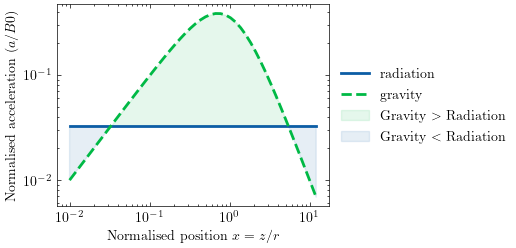


signal (15): Terminated
in expression starting at /home/arnau/.julia/packages/IJulia/e8kqU/src/kernel.jl:53
epoll_wait at /usr/lib/libc.so.6 (unknown line)
uv__io_poll at /workspace/srcdir/libuv/src/unix/linux-core.c:309
uv_run at /workspace/srcdir/libuv/src/unix/core.c:379
jl_task_get_next at /buildworker/worker/package_linux64/build/src/partr.c:472
poptask at ./task.jl:755
wait at ./task.jl:763 [inlined]
wait at ./condition.jl:106


In [193]:
r0 = 7

fig, ax = plt.subplots()
normalised_radiation = rad_normalized(bh, r0) * ones(length(x_range))
normalised_gravity = grav_normalized.(Ref(bh), x_range, r0)
ax.loglog(x_range, normalised_radiation, label="radiation", linewidth=2)
ax.loglog(x_range, normalised_gravity, label = "gravity", linewidth=2, linestyle="--")
ax.fill_between(x_range, normalised_radiation, normalised_gravity, where=(normalised_radiation .< normalised_gravity), alpha=0.1, color="C1", interpolate=true, label=L"Gravity $>$ Radiation")
ax.fill_between(x_range, normalised_radiation, normalised_gravity, where=(normalised_radiation .> normalised_gravity), alpha=0.1, color="C0", interpolate=true, label=L"Gravity $<$ Radiation")


ax.set_xlabel(L"Normalised position $x=z/r$")
ax.set_ylabel(L"Normalised acceleration $(a / B0)$")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
fig.savefig("./plots/radiation_vs_gravity.pdf", bbox_inches="tight")


# 5 Regions of the solution space

In [120]:
using PyCall, Printf

In [29]:
mnras_width = 252/72.27
inset_locator = pyimport("mpl_toolkits.axes_grid1.inset_locator")
zoomed_inset_axes =  inset_locator.zoomed_inset_axes
mark_inset = inset_locator.mark_inset

PyObject <function mark_inset at 0x7f31a2e5aee0>

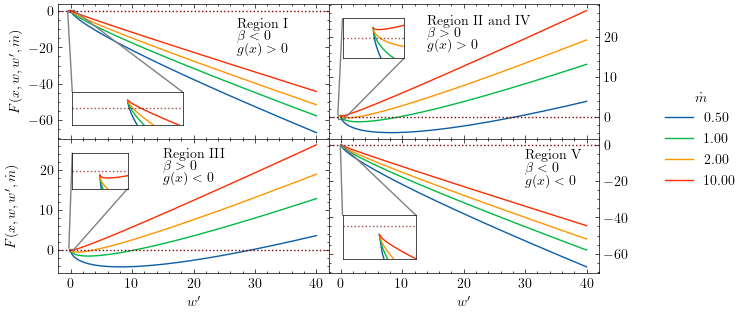

In [125]:
fig, ax = plt.subplots(2,2, sharex=true, figsize=(2*mnras_width, mnras_width))
mdot_range = [0.5, 1, 2, 10]
subsonic_w = -1
supersonic_w  = 0.77


# region 1
axins = zoomed_inset_axes(ax[1,1], 18, loc="lower left", borderpad=1) # zoom-factor: 2.5, location: upper-left
wp_range = 10 .^ range(-3, log10(40), length=5000)
for mdot in mdot_range
    ax[1,1].plot(wp_range, F.(Ref(bh), 1, wp_range, subsonic_w, mdot=mdot), label = L"$x$= 1, $\dot m$= $mdot")
    axins.plot(wp_range, F.(Ref(bh), 1, wp_range, subsonic_w, mdot=mdot), label = L"$x$= 1, $\dot m$= $mdot")
end
axins.axhline(0, color="maroon", linestyle=":", alpha=0.7)
mark_inset(ax[1,1], axins, loc1=2, loc2=1, fc="none", ec="0.5")
x1, x2, y1, y2 = -0.5, 0.5, -0.5, 0.5 # specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits
axins.get_xaxis().set_ticks([])
axins.get_yaxis().set_ticks([])
#ax[0,0].legend(loc="upper right", borderpad=1.5)
ax[1,1].axhline(0, color="maroon", linestyle=":")
ax[1,1].text(27, -9, "Region I", weight="bold")
ax[1,1].text(27, -16, L"$\beta < 0$")
ax[1,1].text(27, -23, L"$g(x)>0$")

# region 2 and 4
axins = zoomed_inset_axes(ax[1,2], 10, loc="upper left", borderpad=1) # zoom-factor: 2.5, location: upper-left
wp_range = range(0,40, length=5000)
for mdot in mdot_range
    ax[1,2].plot(wp_range, F.(Ref(bh), 1, wp_range, supersonic_w, mdot=mdot), label = L"$x$= 1, $\dot m$= $mdot")
    axins.plot(wp_range, F.(Ref(bh), 1, wp_range, supersonic_w, mdot=mdot), label = L"$x$= 1, $\dot m$= $mdot")
end
    
axins.axhline(0, color="maroon", linestyle=":", alpha=0.7)
mark_inset(ax[1,2], axins, loc1=2, loc2=4, fc="none", ec="0.5")
x1, x2, y1, y2 = -0.5, 0.5, -0.5, 0.5 # specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits
axins.get_xaxis().set_ticks([])
axins.get_yaxis().set_ticks([])
#ax[0,1].legend(loc='upper center', fontsize=12)
ax[1,2].axhline(0, color="maroon", linestyle=":")
ax[1,2].yaxis.tick_right()
ax[1,2].yaxis.set_ticks_position("both")

ax[1,2].text(14, 23, "Region II and IV", weight="bold")
ax[1,2].text(14, 20, L"$\beta > 0$")
ax[1,2].text(14, 17, L"$g(x)>0$")

# Region 3
axins = zoomed_inset_axes(ax[2,1], 15, loc="upper left", borderpad = 1) # zoom-factor: 2.5, location: upper-left
wp_range = range(0,40, length=5000)
x=10
for mdot in mdot_range
    ax[2,1].plot(wp_range, F.(Ref(bh), x, wp_range, supersonic_w, mdot=mdot), label = L"$x$= 1, $\dot m$= $mdot")
    axins.plot(wp_range, F.(Ref(bh), x, wp_range,  supersonic_w, mdot=mdot), label = L"$x$= 1, $\dot m$= $mdot")
end
    
axins.axhline(0, color="maroon", linestyle=":", alpha=0.7)
mark_inset(ax[2,1], axins, loc1=2, loc2=4, fc="none", ec="0.5")
x1, x2, y1, y2 = -0.3, 0.3, -0.3, 0.3 # specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits
axins.get_xaxis().set_ticks([])
axins.get_yaxis().set_ticks([])
#ax[1,0].legend(loc='upper center', fontsize=12)
ax[2,1].axhline(0, color="maroon", linestyle=":")
ax[2,1].text(15, 23, "Region III", weight="bold")
ax[2,1].text(15, 20, L"$\beta > 0$")
ax[2,1].text(15, 17, L"$g(x)<0$")


# Region 5

axins = zoomed_inset_axes(ax[2,2], 60, loc="lower left", borderpad=1) # zoom-factor: 2.5, location: upper-left
wp_range = range(0, 40, length=5000)
x=10
wfactor = -0.77
for mdot in mdot_range
    ax[2,2].plot(wp_range, F.(Ref(bh), x, wp_range, subsonic_w, mdot=mdot), label = L"$\dot m$= $mdot")
    axins.plot(wp_range, F.(Ref(bh), x, wp_range, subsonic_w, mdot=mdot), label = L"$\dot m$= $mdot")
end
#
axins.axhline(0, color="maroon", linestyle=":", alpha=0.7)
mark_inset(ax[2,2], axins, loc1=2, loc2=1, fc="none", ec="0.5")
x1, x2, y1, y2 = -0.1, 0.1, -0.3, 0.1 # specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits
axins.get_xaxis().set_ticks([])
axins.get_yaxis().set_ticks([])
##ax[1,1].legend(loc='upper right', fontsize=12, borderpad=1.5)
ax[2,2].axhline(0, color="maroon", linestyle=":")
ax[2,2].yaxis.tick_right()
ax[2,2].yaxis.set_ticks_position("both")
#
ax[2,2].text(30, -8, "Region V", weight="bold")
ax[2,2].text(30, -15, L"$\beta < 0$")
ax[2,2].text(30, -22, L"$g(x)<0$")


# labels

legend_lines = [plot([0], [0], color = "C$i")[1] for i in [0,1,2,3]]
legend_labels = [@sprintf "%.2f"  mdot for mdot in [0.5, 1, 2, 10]]

ax[2,2].legend(legend_lines, legend_labels, loc="center left", bbox_to_anchor=(1.2, 1), title = L"\dot m")


ax[2,1].set_xlabel(L"$w'$")
ax[2,2].set_xlabel(L"$w'$")

ax[2,1].set_ylabel(L"$F(x, w, w', \dot m)$", labelpad=15)
ax[1,1].set_ylabel(L"$F(x, w, w', \dot m)$")

plt.subplots_adjust(wspace=0, hspace=0)
fig.savefig("plots/cak_regions.pdf", bbox_inches="tight")
##fig.savefig("regions.pdf", bbox_inches="tight")

# Initial Conditions

## Surface mass loss rate

In [130]:
radiation = QsosedRadiation();

In [186]:
r_range = 10 .^ range(log10(7), log10(1000), length=1000);

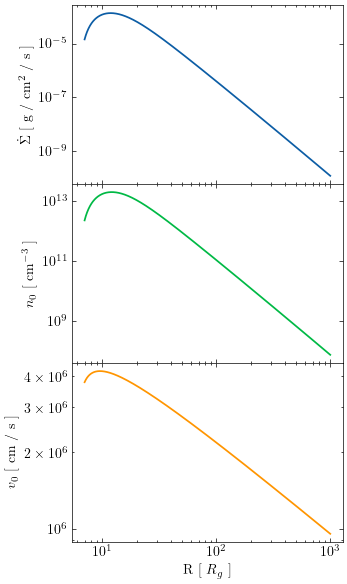

In [191]:
surface_mloss  = cak_surface_mloss.(Ref(radiation), Ref(bh), r_range);
initial_densities  = cak_density.(Ref(radiation), Ref(bh), r_range);
initial_velocities  = compute_thermal_velocity.(disk_temperature.(Ref(bh), r_range)) .* C

fig, ax = plt.subplots(3, 1, sharex=true, figsize=(mnras_width, 2 * mnras_width))
ax[1].loglog(r_range, surface_mloss, color = "C0", linewidth=1.25)
#ax[1].set_xlabel(L"R [ $R_g$ ]")
ax[1].set_ylabel(L"$\dot \Sigma$ [ g / cm$^2$ / s ]")

ax[2].loglog(r_range, initial_densities, color = "C1", linewidth=1.25)
#ax[2].set_xlabel(L"R [ $R_g$ ]")
ax[2].set_ylabel(L"$n_0$ [ cm$^{-3}$ ]")

ax[3].loglog(r_range, initial_velocities, color = "C2", linewidth=1.25)
ax[3].set_xlabel(L"R [ $R_g$ ]")
ax[3].set_ylabel(L"$v_0$ [ cm / s ]")

plt.subplots_adjust(hspace=0)

fig.savefig("./plots/initial_conditions.pdf", bbox_inches="tight")